# May 24th, 2021

**Motivation**: ANTs spatial transformation: finally worked. Allen SDK: more exploration. </br>

In [1]:
import os
import ants
import nrrd

import sys
import collections
import numpy as np
import pandas as pd
import nibabel as nib
import operator as op
from os.path import join as pjoin

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# GitHub
git_path = pjoin(os.environ['HOME'], 'Dropbox/git/Ca-fMRI/')
sys.path.insert(0, git_path)
from utils.processing import *

In [2]:
def trim_axs(axes, n):
    axs = axes.flat
    for ax in axs[n:]:
        ax.remove()
    return axs[:n]

In [3]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Allen SDK

In [4]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.api.queries.ontologies_api import OntologiesApi

# tell the cache class what resolution (in microns) of data you want to download
mcc = MouseConnectivityCache(resolution=100)

# use the structure tree class to get information about the isocortex structure
structure_tree = mcc.get_structure_tree()
isocortex_id = structure_tree.get_structures_by_name(['Isocortex'])[0]['id']

experiment_id = 180436360

# download the projection density volume for one of the experiments
pjd, pjd_info = mcc.get_projection_density(experiment_id)

# injection density: number of projecting pixels in injection site / voxel volume
ind, ind_info = mcc.get_injection_density(experiment_id)

# injection fraction: number of pixels in injection site / voxel volume
inf, inf_info = mcc.get_injection_fraction(experiment_id)

# binary mask indicating which voxels contain valid data
dm, dm_info = mcc.get_data_mask(experiment_id)
dm[dm > 0] = 1
dm = dm.astype(bool)


# template and annotation info
template, template_info = mcc.get_template_volume()
annot, annot_info = mcc.get_annotation_volume()

# in addition to the annotation volume, you can get binary masks for individual structures
# in this case, we'll get one for the isocortex
cortex_mask, cm_info = mcc.get_structure_mask(315)

## Spatial normalization using ANTs

### Mouse #1: sub-SLC06

In [5]:
subject = 6
session = 1
raw_dir = '/mnt/storage/hadi/Ca-fMRI/raw/sub-SLC{:02d}/ses-{:d}'
raw_dir = raw_dir.format(subject, session)

In [6]:
# load
anat_file = 'anat/sub-SLC{:02d}_ses-{:d}_space-individual_T1w.nii.gz'.format(subject, session)
anat_file = pjoin(raw_dir, anat_file)
mask_file = 'func/sub-SLC{:02d}_ses-{:d}_space-individual_desc-mask_bold.nii.gz'.format(subject, session)
mask_file = pjoin(raw_dir, mask_file)

src = ants.image_read(anat_file, reorient='SAR')
mask = ants.image_read(mask_file, reorient='SAR')

src *= mask
mask = src.get_mask()

# reference image
tgt = ants.from_numpy(template.astype(float), origin=(0, 0, 0))
tgt = ants.resample_image(tgt, [2] * 3)

src, mask, tgt = list(
    ants.from_numpy(img.numpy().astype(float), origin=(0, 0, 0))
    for img in [src, mask, tgt]
)
src.shape, tgt.shape

((78, 64, 64), (66, 40, 57))

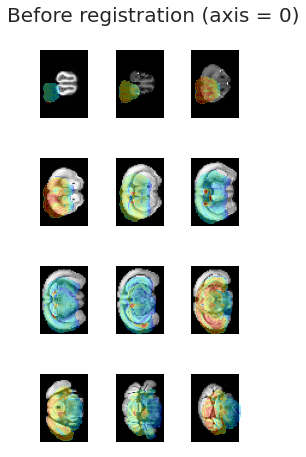

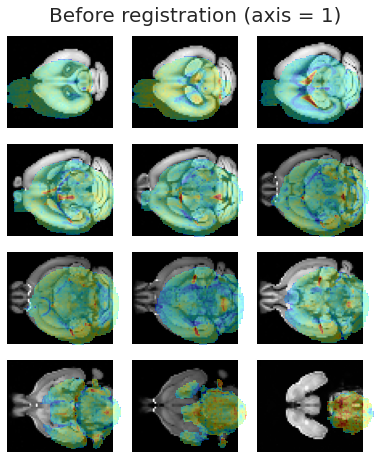

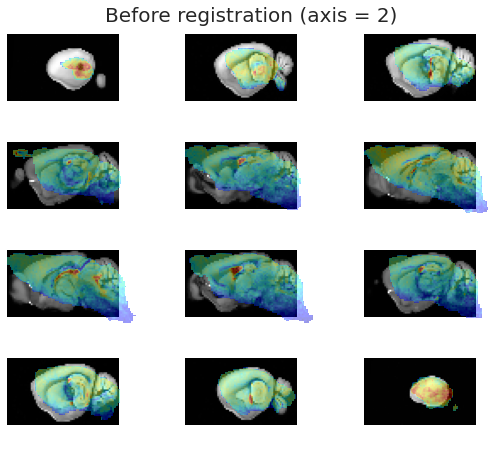

In [7]:
for axis in range(3):
    tgt.plot(
        overlay=src,
        overlay_alpha=0.4,
        axis=axis,
        figsize=1.5,
        reorient=False,
        title='Before registration (axis = {:d})'.format(axis),
    )

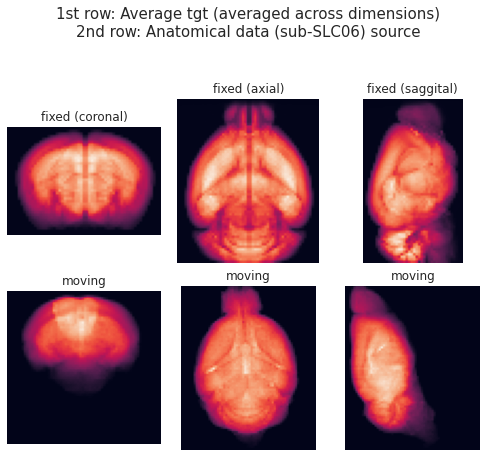

In [8]:
sns.set_style('white')
fig, axes = plt.subplots(2, 3, figsize=(7, 6))

for i in range(2):
    for j in range(3):
        if i == 0:
            data2plt = tgt.numpy()
            title = 'fixed'
        else:
            data2plt = src.numpy()
            title = 'moving'

        if i == 0:
            if j == 0:
                title += ' (coronal)'
            elif j == 1:
                title += ' (axial)'
            else:
                title += ' (saggital)'

        axes[i, j].imshow(data2plt.mean(j))
        axes[i, j].set_title(title)
        axes[i, j].axis('off')

msg = '1st row: Average tgt (averaged across dimensions)\n'
msg += '2nd row: Anatomical data (sub-SLC06) source'
plt.suptitle(msg, fontsize=15, y=1.05)
plt.tight_layout()
plt.show()

### Register

In [9]:
tx = ants.registration(
    fixed=tgt,
    moving=src,
    mask=mask,
    type_of_transform='SyN',
    verbose=True,
)

In [10]:
tx.keys()

dict_keys(['warpedmovout', 'warpedfixout', 'fwdtransforms', 'invtransforms'])

In [11]:
src_tr = ants.apply_transforms(
    fixed=tgt,
    moving=src,
    transformlist=tx['fwdtransforms'],
    interpolator='linear',
)
src_tr

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (66, 40, 57)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

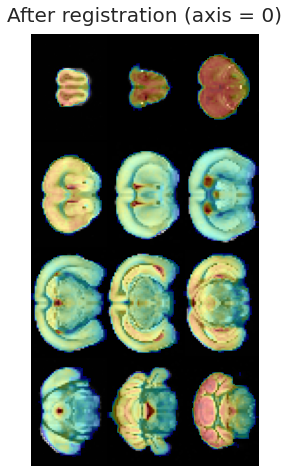

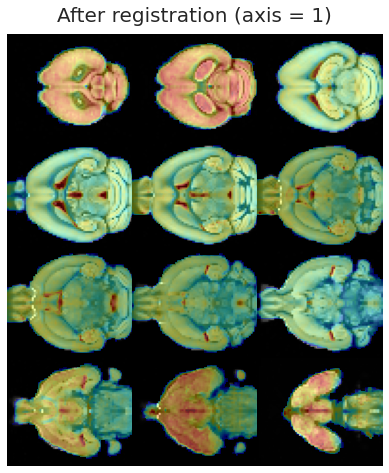

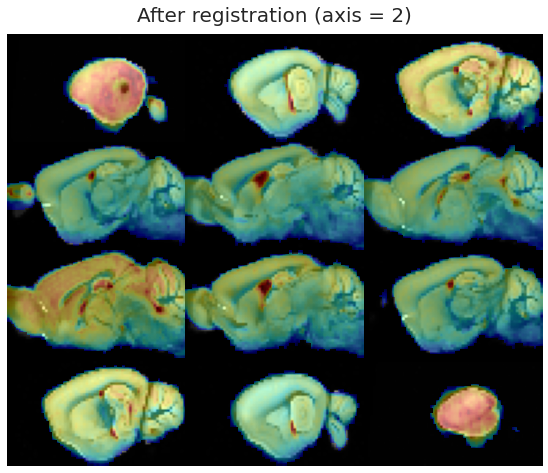

In [12]:
for axis in range(3):
    tgt.plot(
        overlay=src_tr,
        overlay_alpha=0.4,
        axis=axis,
        figsize=1.5,
        reorient=False,
        title='After registration (axis = {:d})'.format(axis),
    )

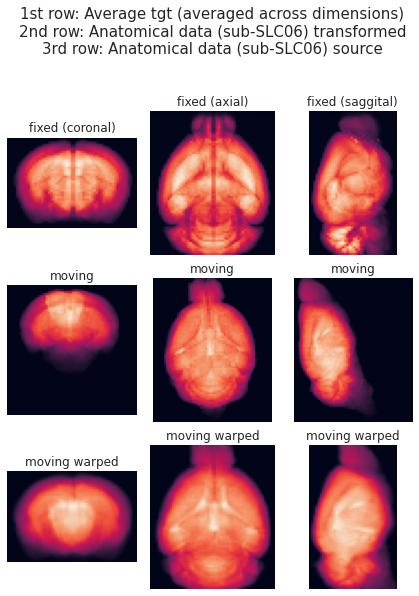

In [13]:
sns.set_style('white')
fig, axes = plt.subplots(3, 3, figsize=(6, 8))

for i in range(3):
    for j in range(3):
        if i == 0:
            data2plt = tgt.numpy()
            title = 'fixed'
        elif i == 1:
            data2plt = src.numpy()
            title = 'moving'
        else:
            data2plt = src_tr.numpy()
            title = 'moving warped'
        
        if i == 0:
            if j == 0:
                title += ' (coronal)'
            elif j == 1:
                title += ' (axial)'
            else:
                title += ' (saggital)'

        axes[i, j].imshow(data2plt.mean(j))
        axes[i, j].set_title(title)
        axes[i, j].axis('off')

msg = '1st row: Average tgt (averaged across dimensions)\n'
msg += '2nd row: Anatomical data (sub-SLC{:02d}) transformed\n'
msg += '3rd row: Anatomical data (sub-SLC{:02d}) source'
plt.suptitle(msg.format(subject, subject), fontsize=15, y=1.03)
plt.tight_layout()
plt.show()

### Mouse #2: sub-SLC02

In [14]:
subject = 2
session = 1
raw_dir = '/mnt/storage/hadi/Ca-fMRI/raw/sub-SLC{:02d}/ses-{:d}'
raw_dir = raw_dir.format(subject, session)

In [15]:
# load
anat_file = 'anat/sub-SLC{:02d}_ses-{:d}_space-individual_T1w.nii.gz'.format(subject, session)
anat_file = pjoin(raw_dir, anat_file)
mask_file = 'func/sub-SLC{:02d}_ses-{:d}_space-individual_desc-mask_bold.nii.gz'.format(subject, session)
mask_file = pjoin(raw_dir, mask_file)

src = ants.image_read(anat_file, reorient='SAR')
mask = ants.image_read(mask_file, reorient='SAR')

src *= mask
mask = src.get_mask()

# reference image
tgt = ants.from_numpy(template.astype(float), origin=(0, 0, 0))
tgt = ants.resample_image(tgt, [2] * 3)

src, mask, tgt = list(
    ants.from_numpy(img.numpy().astype(float), origin=(0, 0, 0))
    for img in [src, mask, tgt]
)
src.shape, tgt.shape

((78, 64, 64), (66, 40, 57))

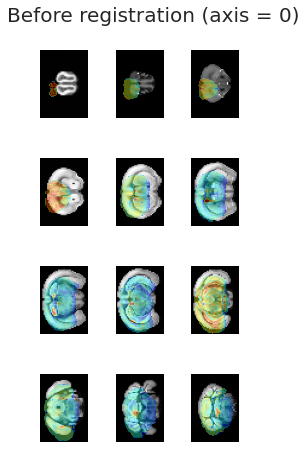

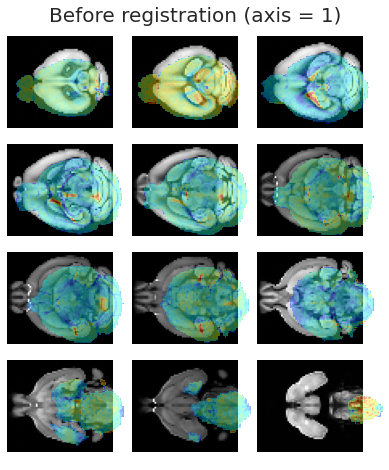

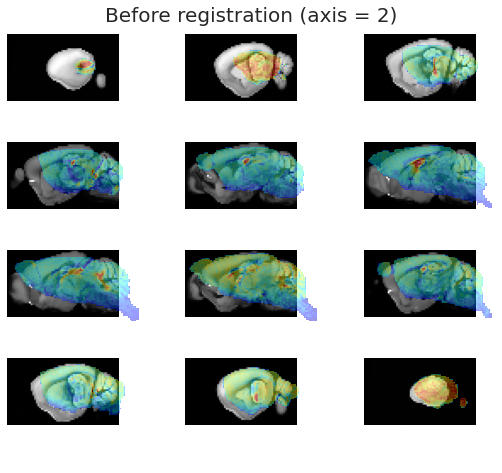

In [16]:
for axis in range(3):
    tgt.plot(
        overlay=src,
        overlay_alpha=0.4,
        axis=axis,
        figsize=1.5,
        reorient=False,
        title='Before registration (axis = {:d})'.format(axis),
    )

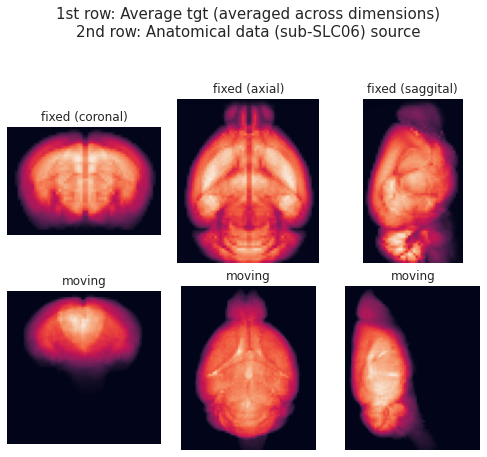

In [17]:
sns.set_style('white')
fig, axes = plt.subplots(2, 3, figsize=(7, 6))

for i in range(2):
    for j in range(3):
        if i == 0:
            data2plt = tgt.numpy()
            title = 'fixed'
        else:
            data2plt = src.numpy()
            title = 'moving'

        if i == 0:
            if j == 0:
                title += ' (coronal)'
            elif j == 1:
                title += ' (axial)'
            else:
                title += ' (saggital)'

        axes[i, j].imshow(data2plt.mean(j))
        axes[i, j].set_title(title)
        axes[i, j].axis('off')

msg = '1st row: Average tgt (averaged across dimensions)\n'
msg += '2nd row: Anatomical data (sub-SLC06) source'
plt.suptitle(msg, fontsize=15, y=1.05)
plt.tight_layout()
plt.show()

### Register

In [18]:
tx = ants.registration(
    fixed=tgt,
    moving=src,
    mask=mask,
    type_of_transform='SyN',
    verbose=True,
)

In [19]:
src_tr = ants.apply_transforms(
    fixed=tgt,
    moving=src,
    transformlist=tx['fwdtransforms'],
    interpolator='linear',
)
src_tr

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (66, 40, 57)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

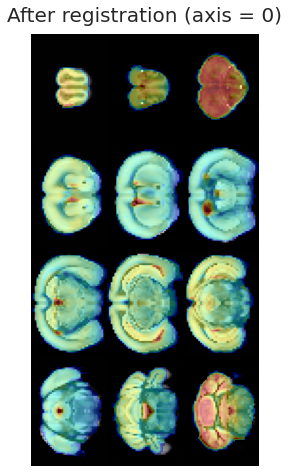

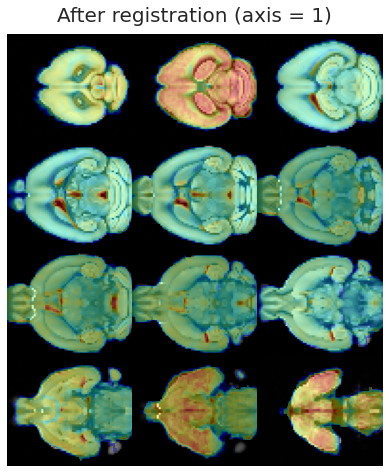

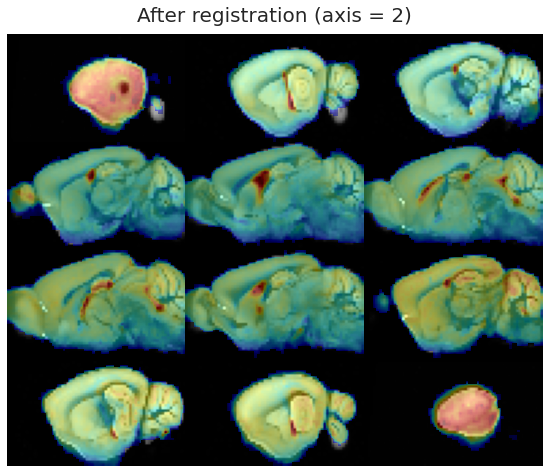

In [20]:
for axis in range(3):
    tgt.plot(
        overlay=src_tr,
        overlay_alpha=0.4,
        axis=axis,
        figsize=1.5,
        reorient=False,
        title='After registration (axis = {:d})'.format(axis),
    )

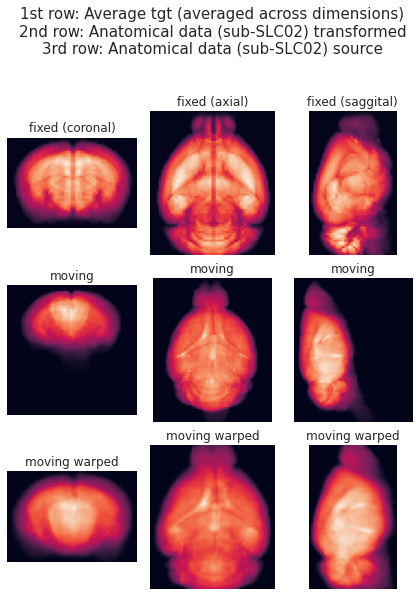

In [21]:
sns.set_style('white')
fig, axes = plt.subplots(3, 3, figsize=(6, 8))

for i in range(3):
    for j in range(3):
        if i == 0:
            data2plt = tgt.numpy()
            title = 'fixed'
        elif i == 1:
            data2plt = src.numpy()
            title = 'moving'
        else:
            data2plt = src_tr.numpy()
            title = 'moving warped'
        
        if i == 0:
            if j == 0:
                title += ' (coronal)'
            elif j == 1:
                title += ' (axial)'
            else:
                title += ' (saggital)'

        axes[i, j].imshow(data2plt.mean(j))
        axes[i, j].set_title(title)
        axes[i, j].axis('off')

msg = '1st row: Average tgt (averaged across dimensions)\n'
msg += '2nd row: Anatomical data (sub-SLC{:02d}) transformed\n'
msg += '3rd row: Anatomical data (sub-SLC{:02d}) source'
plt.suptitle(msg.format(subject, subject), fontsize=15, y=1.03)
plt.tight_layout()
plt.show()

## Allen Reference Atlas (ARA)

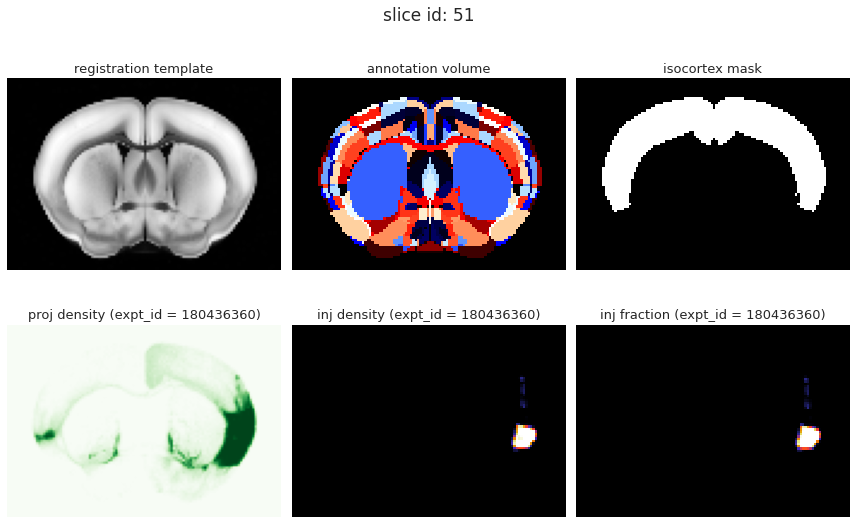

In [22]:
slice_idx = 51 # np.argmax(np.abs(pjd).mean(-1).mean(-1))
nrows, ncols = 2, 3
fig, ccf_axes = plt.subplots(nrows, ncols, figsize=(12, 8))

for i in range(nrows):
    for j in range(ncols):
        
        interpolation = 'none'
        vmin, vmax = None, None
        
        if (i, j) == (0, 0):
            data2plt = template[slice_idx]
            cmap = 'Greys_r'
            interpolation = 'antialiased'
            title = 'registration template'
            
        elif (i, j) == (0, 1):
            data2plt = annot[slice_idx]
            cmap = 'flag_r'
            title = 'annotation volume'
            vmin = 0
            vmax = 2000
            
        elif (i, j) == (0, 2):
            data2plt = cortex_mask[slice_idx]
            cmap = 'Greys_r'
            title = 'isocortex mask'
            
        elif (i, j) == (1, 0):
            data2plt = pjd[slice_idx]
            cmap = 'Greens'
            interpolation = 'antialiased'
            title = 'proj density (expt_id = {:d})'.format(experiment_id)
            
        elif (i, j) == (1, 1):
            data2plt = ind[slice_idx]
            cmap = 'CMRmap'
            title = 'inj density (expt_id = {:d})'.format(experiment_id)
        else:
            data2plt = inf[slice_idx]
            cmap = 'CMRmap'
            title = 'inj fraction (expt_id = {:d})'.format(experiment_id)
        
        # apply mask
        data2plt = data2plt.astype(float)
        data2plt *= dm[slice_idx]
        
        
        ccf_axes[i, j].imshow(
            X=data2plt,
            cmap=cmap,
            aspect='equal',
            interpolation=interpolation,
            vmin=vmin,
            vmax=vmax,
        )
        ccf_axes[i, j].set_title(title, fontsize=13)
        ccf_axes[i, j].axis('off')

fig.suptitle("slice id: {:d}".format(slice_idx), fontsize=17)
fig.tight_layout()
plt.show()

## Allen SDK (play more)

### Allen Reference Atlas (ARA)

> The Allen Mouse Brain Atlas includes a full-color, high-resolution anatomic reference atlas accompanied by a systematic, hierarchically organized taxonomy of mouse brain structures.

> For more information, please refer to the [documentation](http://help.brain-map.org/display/mousebrain/Documentation).

Here I show how to access this data using Allen SDK.  [Click here for an example slice from online, interactive version](http://atlas.brain-map.org/atlas?atlas=1&plate=100960224#atlas=1&plate=100960084&resolution=11.97&x=5278.874860491072&y=3775.9999956403462&zoom=-3&z=6).

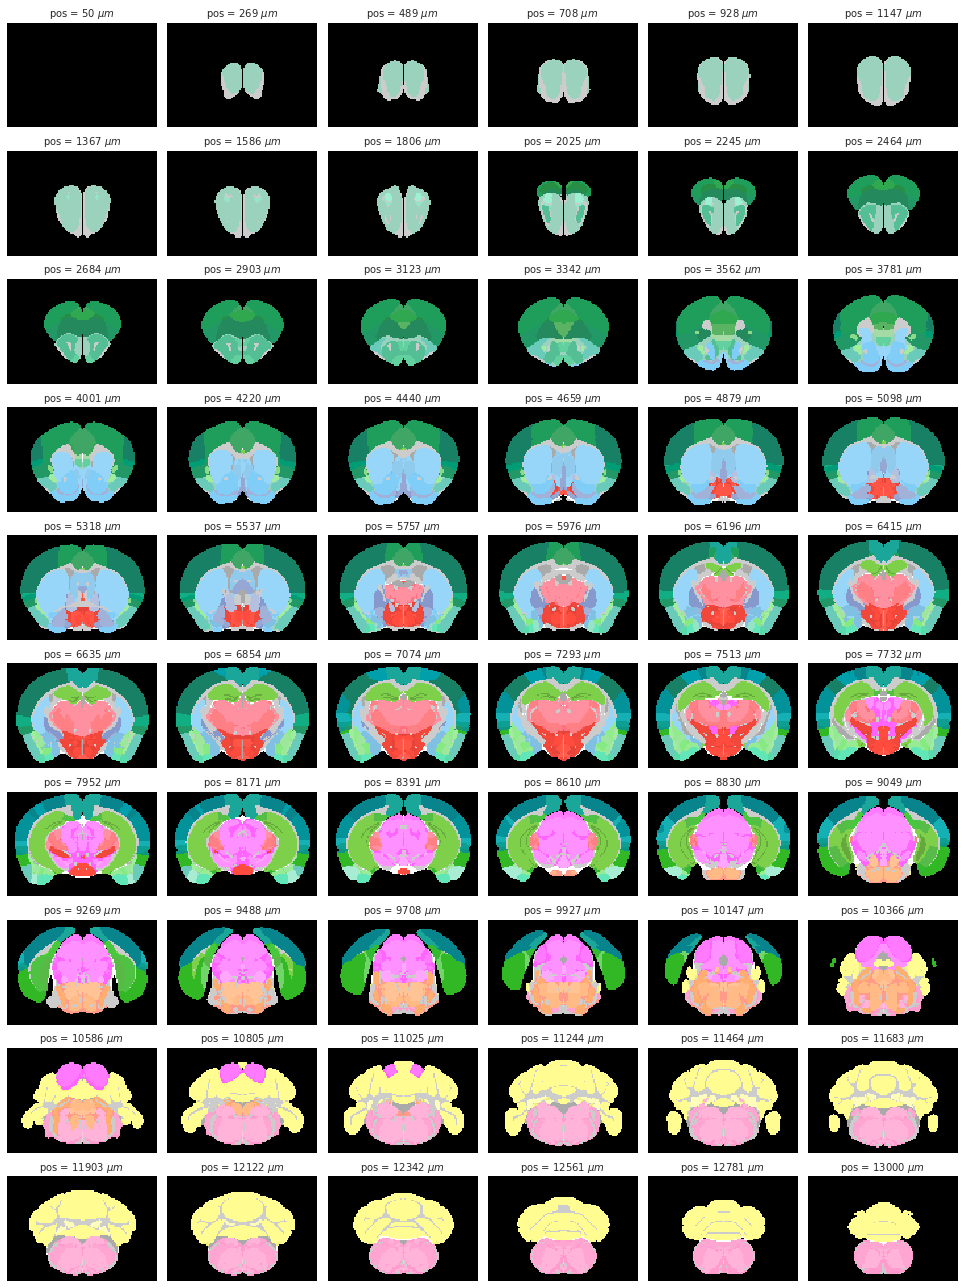

In [23]:
ara = mcc.get_reference_space()


lower = 50
upper = 13000

nrows, ncols = 10, 6
num = nrows * ncols - 1
spacing = (upper - lower) / num

sns.set_style('white')
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 18))
for i in range(nrows):
    for j in range(ncols):
        idx = i * ncols + j
        pos = lower + idx * spacing
        axes[i, j].imshow(ara.get_slice_image(axis=0, position=pos), interpolation='none')
        axes[i, j].set_title(r"pos = {:.0f} $\mu m$".format(pos), fontsize=10)
        axes[i, j].axis('off')

fig.tight_layout()
plt.show()

### Get projection matrix

In [24]:
expts = [experiment_id, 156741826, 126116848, 100141780]
expts

[180436360, 156741826, 126116848, 100141780]

In [25]:
pm_dict = mcc.get_projection_matrix(expts)
pm_dict.keys()

dict_keys(['matrix', 'rows', 'columns'])

In [26]:
pm_dict['matrix'].shape

(4, 948)

In [27]:
len(pm_dict['columns'])

948

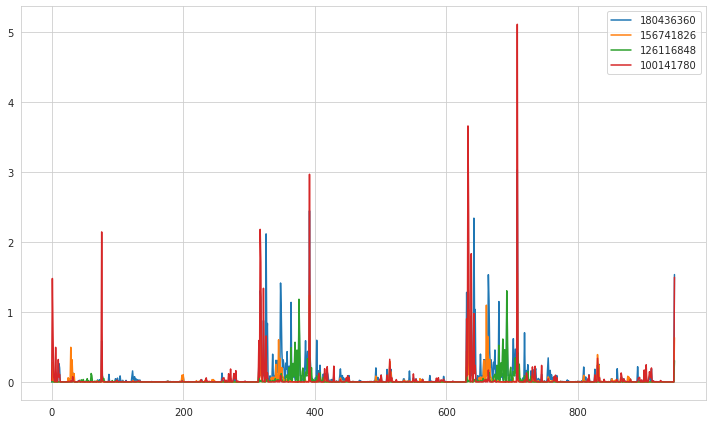

In [28]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for expt_id, vec in zip(pm_dict['rows'], pm_dict['matrix']):
    ax.plot(vec, label=expt_id)
    ax.legend()
fig.tight_layout()
plt.show()

In [29]:
pm_dict['columns']

[{'hemisphere_id': 1, 'structure_id': 184, 'label': 'FRP-L'},
 {'hemisphere_id': 1, 'structure_id': 985, 'label': 'MOp-L'},
 {'hemisphere_id': 1, 'structure_id': 993, 'label': 'MOs-L'},
 {'hemisphere_id': 1, 'structure_id': 353, 'label': 'SSp-n-L'},
 {'hemisphere_id': 1, 'structure_id': 329, 'label': 'SSp-bfd-L'},
 {'hemisphere_id': 1, 'structure_id': 337, 'label': 'SSp-ll-L'},
 {'hemisphere_id': 1, 'structure_id': 345, 'label': 'SSp-m-L'},
 {'hemisphere_id': 1, 'structure_id': 369, 'label': 'SSp-ul-L'},
 {'hemisphere_id': 1, 'structure_id': 361, 'label': 'SSp-tr-L'},
 {'hemisphere_id': 1, 'structure_id': 182305689, 'label': 'SSp-un-L'},
 {'hemisphere_id': 1, 'structure_id': 378, 'label': 'SSs-L'},
 {'hemisphere_id': 1, 'structure_id': 1057, 'label': 'GU-L'},
 {'hemisphere_id': 1, 'structure_id': 677, 'label': 'VISC-L'},
 {'hemisphere_id': 1, 'structure_id': 1011, 'label': 'AUDd-L'},
 {'hemisphere_id': 1, 'structure_id': 1002, 'label': 'AUDp-L'},
 {'hemisphere_id': 1, 'structure_id': 1